In [1]:
import warnings
warnings.filterwarnings('ignore')
import FateAxis.tool.main_function as fa
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import FateAxis.tool.extractor as ext
import cospar as cs
import wot
import scipy.stats as stats
from scipy.stats import rankdata
import FateAxis.tool.preprocessor as pp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/AEGAS_data/fate/CellTag2018.h5ad')
#adata = adata[adata.obs['celltype']!='Others']
adata.obs['day'] = 2
adata.obs.loc[adata.obs['celltype'].isin(['Others']), 'day'] = 1

In [3]:
ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 
#tmaps = ot_model.compute_transport_map(2,1,tmap_out='/data/jiangjunyao/easyGRN/processed_data/mouse_hematopoiesis/ot/')
ot_model.compute_all_transport_maps(tmap_out='/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep/ot/')
celltype_dict = adata.obs.groupby('celltype').apply(lambda x: x.index.tolist()).to_dict()
print(celltype_dict.keys())
tmap_model = wot.tmap.TransportMapModel.from_directory('/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep/ot/')
target_destinations = tmap_model.population_from_cell_sets(celltype_dict, at_time=2)
fate_ds = tmap_model.fates(target_destinations)
max_indices = np.argmax(fate_ds.X, axis=1)

max_var_names = [fate_ds.var_names[idx] for idx in max_indices]

result = list(max_var_names)
fate_ds.obs['pred'] = result

2025-07-02 01:26:11,349 - INFO - Computing transport map from 1 to 2


dict_keys(['Failed', 'Others', 'Reprogrammed'])


In [4]:
common_index = adata.obs.index.intersection(fate_ds.obs.index)
fate_data = fate_ds.obs.loc[common_index, 'pred']
adata.obs.loc[common_index, 'pred'] = fate_data
from sklearn.metrics import accuracy_score, recall_score, f1_score

adata_filter = adata[adata.obs.celltype.isin(['early','Others'])]
y_pred = adata_filter.obs['pred']
y_true = adata_filter.obs['lineage']

accuracy = accuracy_score(y_true, y_pred)

recall = recall_score(y_true, y_pred, average='macro')


f1 = f1_score(y_true, y_pred, average='macro')


print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.2007936507936508
Recall: 0.0893361581920904
F1 Score: 0.13962472406181015


... storing 'pred' as categorical


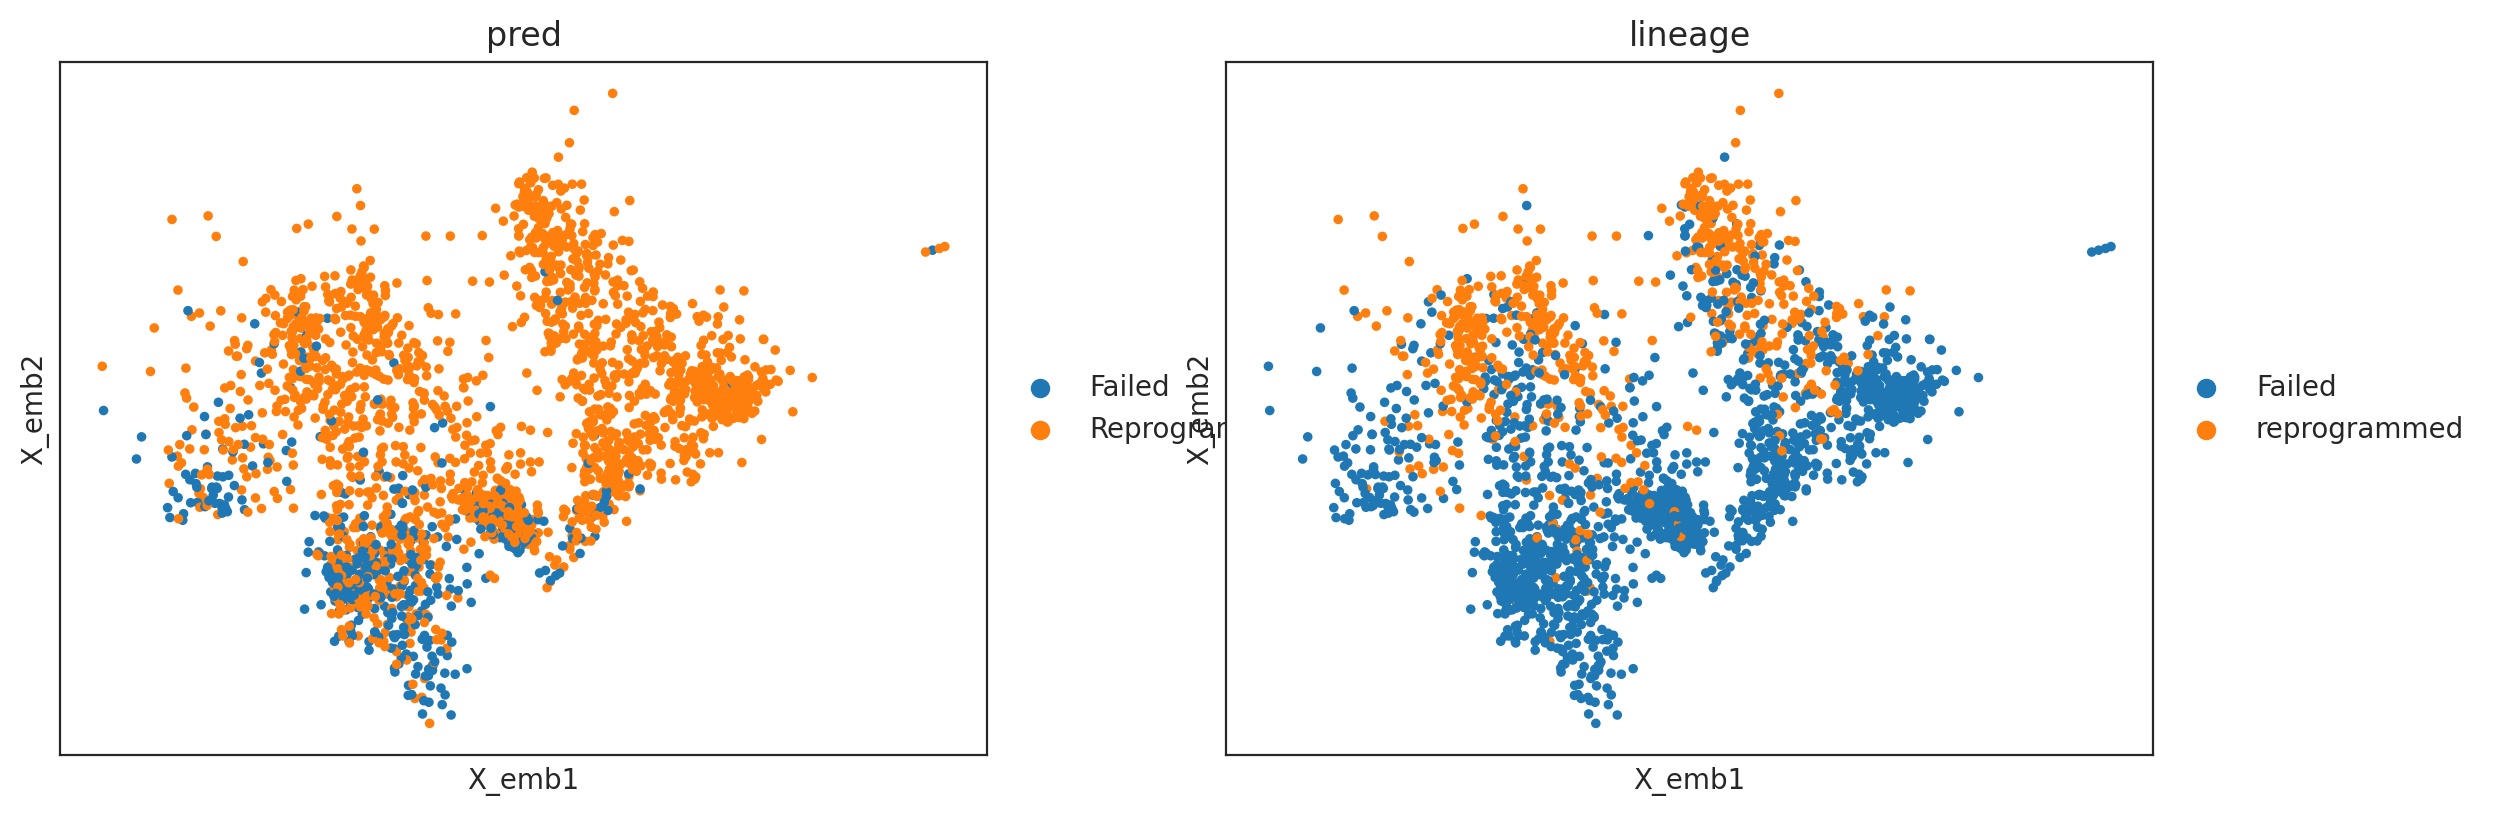

In [5]:
sc.pl.embedding(adata_filter,color=['pred','lineage'],basis='X_emb')

In [6]:
adata.write('/data/jiangjunyao/AEGAS_analysis/pred_result/WOT_celltagy.h5ad')
adata.obs.to_csv('/data/jiangjunyao/AEGAS_analysis/pred_result/WOT_celltag_obs.csv')

... storing 'pred' as categorical
